In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bcb import sgs,currency
from fredapi import Fred
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from datetime import date,timedelta
from dateutil.relativedelta import relativedelta
from scipy.optimize import curve_fit
from darts import TimeSeries
from darts.models import BlockRNNModel
from darts.dataprocessing.transformers import Scaler

c:\Users\aruav\Desktop\Deepen\CTG\cambio\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
api_key = '5beeb88b7a5cdd7d4fd8b976e138b52e'
fred = Fred(api_key = api_key)

In [3]:
# Função que converte a variação mensal do IPCA em IPCA absoluto (A série de ipca deve começar em janeiro de 2000)
def absolute(serie):
    valor_atual = 1598.41
    yield valor_atual
    for valor in serie[1:]:
        valor = valor / 100
        valor_atual += (valor_atual * valor)
        yield valor_atual

# Função que puxa as séries temporais usadas pra prever o IPCA
def get_indicators_ipca(start_date):
    dados = {'selic':432,'emprego':28763,'producao':21859,'comercio':1455,'energia':1406,'IPCA_change':433}
    dataframe = sgs.get(dados,start = start_date)
    dataframe = dataframe.resample('m').mean()
    dataframe['indice'] = [valor for valor in absolute(dataframe['IPCA_change'].values)]
    del(dataframe['IPCA_change'])
    dataframe = dataframe.dropna()
    return dataframe

# Função que separa os dados em treino e teste
def train_test_split(xdata,ydata,horizonte):
    meses = horizonte * 12
    y_train,y_test = ydata.iloc[:-meses],ydata.iloc[-meses:]
    x_train,x_test = xdata.iloc[-meses - len(y_train):-meses],xdata.iloc[-meses:]
    return x_train,y_train,x_test,y_test

# Função que puxa os dados usados pra prever o câmbio
def get_indicators_cambio(start_date):
    dados = {'selic':432,'emprego':28763,'ipca':13522,'pib':1208}
    dataframe = sgs.get(dados,start = start_date)
    cy = currency.get('USD', start = start_date,end = str(date.today()))
    dataframe['cambio'] = cy['USD']
    gdp_eua = fred.get_series(series_id = 'GDPC1',observation_start = start_date)
    cpi = fred.get_series(series_id = 'USACPIALLMINMEI',observation_start = f'{int(start_date[:4]) - 1}{start_date[4:]}')
    inflacion_rate = pd.Series(data = (cpi.values[12:] - cpi.values[:-12]) / cpi.values[:-12],index = cpi.iloc[12:].index)
    employment = fred.get_series(series_id = 'CE16OV',observation_start = start_date)
    interest = fred.get_series(series_id = 'INTDSRUSM193N',observation_start = start_date)
    dataframe['pib_eua'] = gdp_eua
    dataframe['cpi'] = inflacion_rate
    dataframe['employment'] = employment
    dataframe['interest_rates'] = interest
    dataframe = dataframe.fillna(method = 'ffill')
    dataframe = dataframe.resample('m').mean()
    return dataframe.iloc[:-2]

def get_indicators_selic(start_date):
    dados = {'selic':432,'IPCA_change':433,'pib':1208}
    dataframe = sgs.get(dados,start = start_date)
    dataframe = dataframe.fillna(method = 'ffill')
    dataframe = dataframe.resample('m').mean()
    dataframe['indice'] = [valor for valor in absolute(dataframe['IPCA_change'].values)]
    del(dataframe['IPCA_change'])
    dataframe = dataframe.dropna()
    return dataframe.iloc[:-2]

In [4]:
# Classe utilizada para criar o modelo LSTM (IPCA)
class LSTM:
    def __init__(self,main_serie,extra_series):
        self.last = main_serie.values[-1]
        self.data = TimeSeries.from_dataframe(main_serie)
        self.extra_data = TimeSeries.from_dataframe(extra_series)
        self.scaler_y = Scaler()
        self.transformed_data = self.scaler_y.fit_transform(self.data)
        self.scaler_x = Scaler()
        self.transformed_extra_data = self.scaler_x.fit_transform(self.extra_data)
    def fit(self,input_size,output_size):
        self.model_cov = BlockRNNModel(
            model = "LSTM",
            input_chunk_length = input_size,
            output_chunk_length = output_size,
            n_epochs = 300,
        )
        self.model_cov.fit(
            series = self.transformed_data,
            past_covariates = self.transformed_extra_data,
            verbose = False,
        )
        return self
    def predict(self,n):
        prediction = self.model_cov.predict(n = n,series = self.transformed_data, past_covariates = self.transformed_extra_data)
        converted_prediction = self.scaler_y.inverse_transform(prediction).values().ravel()
        difference = converted_prediction[0] - self.last
        prediction_final = converted_prediction - difference
        return prediction_final

In [5]:
# Função otilizada para aproximar a curva de câmbio
def simple_square(x,a):
    return (x ** 2) * a

def square(x,a,b,c):
    return ((x ** 2) * a) + (x * b) + c

# Classe utilizada para criar o modelo de regressão + LSTM para o câmbio
class RegressionPlusLSTM:
    def __init__(self,target_data,extra_data,func):
        self.func = func
        self.target_data = target_data
        self.extra_data = extra_data
        self.values = target_data.values.ravel()
        self.x0 = len(target_data)
    
    def fit(self,input_size,output_size):
        # Regressão polinomial no tempo
        self.popt = curve_fit(self.func,list(range(self.x0)),self.values)[0]
        # Sazonalidade
        self.lstm = LSTM(self.target_data,self.extra_data).fit(input_size,output_size)
        return self

    def predict(self,n,peso):
        self.peso = peso
        trend_prediction = np.array([self.func(x,*self.popt) for x in range(self.x0,self.x0 + n)])
        secondary_prediction = self.lstm.predict(n)
        prediction_final = (trend_prediction * self.peso) + (secondary_prediction * (1 - self.peso))
        # Ajustes finais
        last_year_mean = self.values[-12:].mean()
        diferenca = last_year_mean - prediction_final[0]
        prediction_final = prediction_final + diferenca
        micro_diferenca = self.values[-1] - prediction_final[0]
        prediction_final = np.array([prediction_final[i] + (micro_diferenca * (1 - (i / (len(prediction_final) - 1)))) for i in range(len(prediction_final))])
        return prediction_final

<AxesSubplot: xlabel='Date'>

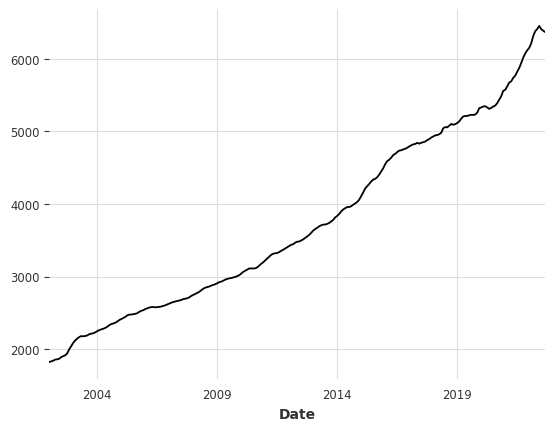

In [6]:
# Puxando e plotando os dados de IPCA
df = get_indicators_ipca('2000-01-01')
ipca = df[['indice']].copy()
df = df.drop(['indice'],axis = 1)
ipca.indice.plot()

In [7]:
# Treinando o modelo de IPCA
anos = 5
x_train,y_train,x_test,y_test = train_test_split(df,ipca,anos)
model = LSTM(y_train,x_train).fit(24,12 * anos)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.


MSE: 22053.17129636714


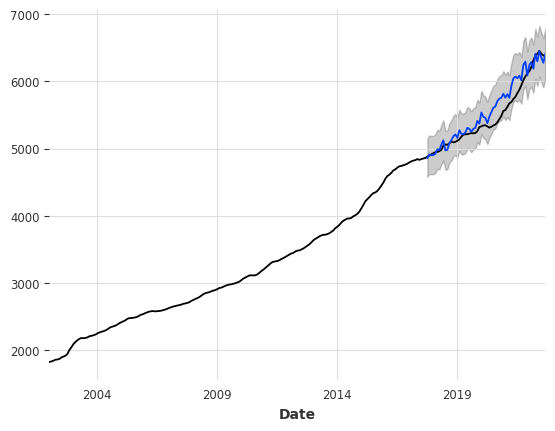

In [8]:
# Plotando o resultado e calculando o Erro
prediction = model.predict(12 * anos)
print('MSE:',mean_squared_error(prediction,y_test))
pred_df = ipca.copy()
pred_df['prediction'] = [None for _ in range(len(pred_df) - len(prediction))] + list(prediction)
pred_df['res'] = ((pred_df['indice'] - pred_df['prediction']) / pred_df['indice']).apply(abs)
pred = pred_df.dropna()
res_max = pred['res'].max()
pred_df['superior'] = [None for _ in range(len(pred_df) - len(prediction))] + [pred + (pred * res_max) for pred in prediction]
pred_df['inferior'] = [None for _ in range(len(pred_df) - len(prediction))] + [pred - (pred * res_max) for pred in prediction]
ax = pred_df['indice'].plot()
pred_df['prediction'].plot()
ax.fill_between(pred_df.index,pred_df['superior'],pred_df['inferior'],color = 'k',alpha = .2)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.


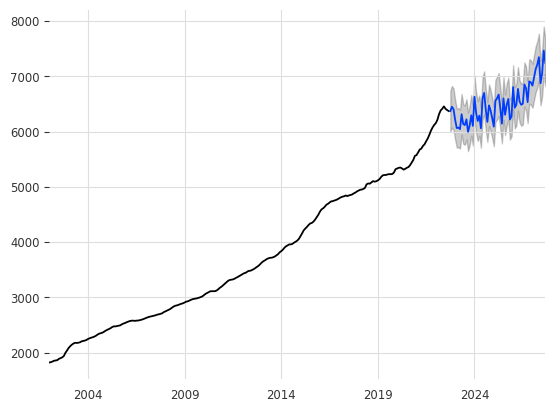

In [9]:
# Treinando novamente o modelo e plotando o Forecast
model = LSTM(ipca,df).fit(24,12 * anos)
prediction = model.predict(12 * anos)
pred_df = pd.concat([ipca.copy(),pd.DataFrame({'prediction':prediction},
    index = pd.date_range(start = ipca.index[-1] + relativedelta(months = 1),periods = len(prediction),freq = 'M'))])
pred_df['superior'] = [None for _ in range(len(pred_df) - len(prediction))] + [pred + (pred * res_max) for pred in prediction]
pred_df['inferior'] = [None for _ in range(len(pred_df) - len(prediction))] + [pred - (pred * res_max) for pred in prediction]
ax = pred_df['indice'].plot()
pred_df['prediction'].plot()
ax.fill_between(pred_df.index,pred_df['superior'],pred_df['inferior'],color = 'k',alpha = .2)

<AxesSubplot: xlabel='Date'>

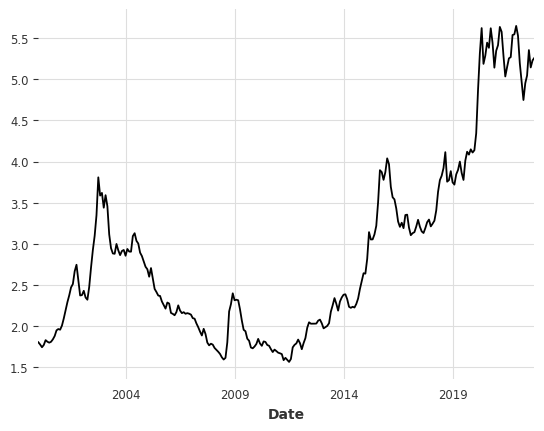

In [10]:
# Puxando e plotando os dados de câmbio
df = get_indicators_cambio('2000-01-01')
cambio = df[['cambio']].copy()
df = df.drop(['cambio'],axis = 1)
cambio.cambio.plot()

In [11]:
# Treinando o modelo de cambio
anos = 5
x_train,y_train,x_test,y_test = train_test_split(df,cambio,anos)
model = RegressionPlusLSTM(y_train,x_train,simple_square).fit(36,12 * anos)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.


MSE: 0.5883243713585895


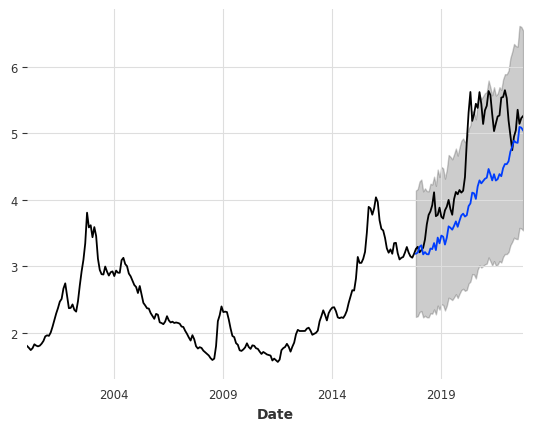

In [12]:
# Plotando o resultado e calculando o Erro
prediction = model.predict(12 * anos,0.6)
print('MSE:',mean_squared_error(prediction,y_test))
pred_df = cambio.copy()
pred_df['prediction'] = [None for _ in range(len(pred_df) - len(prediction))] + list(prediction)
pred_df['res'] = ((pred_df['cambio'] - pred_df['prediction']) / pred_df['cambio']).apply(abs)
pred = pred_df.dropna()
res_max = pred['res'].max()
pred_df['superior'] = [None for _ in range(len(pred_df) - len(prediction))] + [pred + (pred * res_max) for pred in prediction]
pred_df['inferior'] = [None for _ in range(len(pred_df) - len(prediction))] + [pred - (pred * res_max) for pred in prediction]
ax = pred_df['cambio'].plot()
pred_df['prediction'].plot()
ax.fill_between(pred_df.index,pred_df['superior'],pred_df['inferior'],color = 'k',alpha = .2)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.


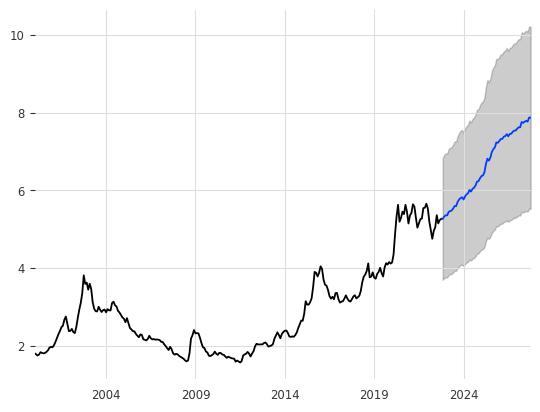

In [13]:
# Treinando novamente o modelo e plotando o Forecast
model = RegressionPlusLSTM(cambio,df,simple_square).fit(36,12 * anos)
prediction = model.predict(12 * anos,0.6)
pred_df = pd.concat([cambio.copy(),pd.DataFrame({'prediction':prediction},
    index = pd.date_range(start = cambio.index[-1] + relativedelta(months = 1),periods = len(prediction),freq = 'M'))])
pred_df['superior'] = [None for _ in range(len(pred_df) - len(prediction))] + [pred + (pred * res_max) for pred in prediction]
pred_df['inferior'] = [None for _ in range(len(pred_df) - len(prediction))] + [pred - (pred * res_max) for pred in prediction]
ax = pred_df['cambio'].plot()
pred_df['prediction'].plot()
ax.fill_between(pred_df.index,pred_df['superior'],pred_df['inferior'],color = 'k',alpha = .2)

<AxesSubplot: xlabel='Date'>

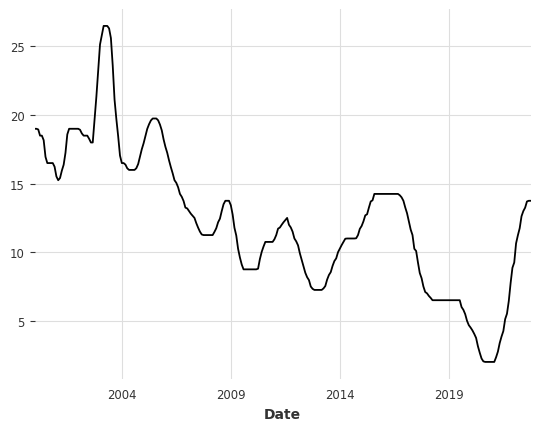

In [14]:
# Puxando e plotando os dados de IPCA
df = get_indicators_selic('2000-01-01')
selic = df[['selic']].copy()
df = df.drop(['selic'],axis = 1)
selic.selic.plot()

In [15]:
# Treinando o modelo de SELIC
anos = 5
x_train,y_train,x_test,y_test = train_test_split(df,selic,anos)
model = RegressionPlusLSTM(y_train,x_train,square).fit(60,12 * anos)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.


MSE: 57.97181602774521


<AxesSubplot: xlabel='Date'>

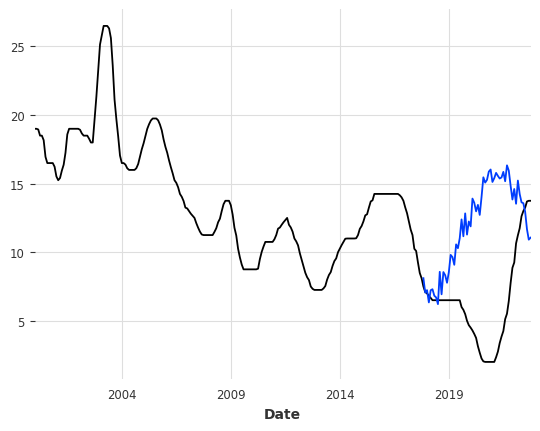

In [16]:
# Plotando o resultado e calculando o Erro
prediction = model.predict(12 * anos,0.2)
print('MSE:',mean_squared_error(prediction,y_test))
pred_df = selic.copy()
pred_df['prediction'] = [None for _ in range(len(pred_df) - len(prediction))] + list(prediction)
pred_df['res'] = (pred_df['selic'] - pred_df['prediction']).apply(abs)
pred = pred_df.dropna()
ax = pred_df['selic'].plot()
pred_df['prediction'].plot()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.


<AxesSubplot: >

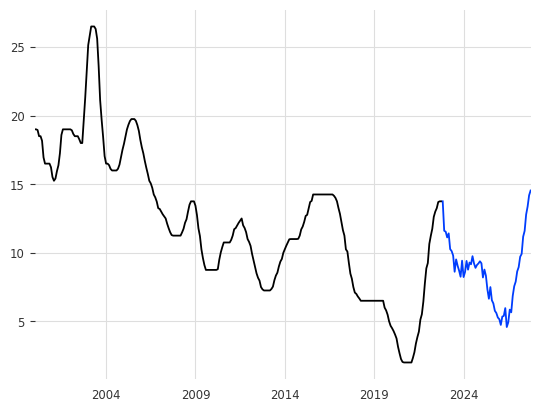

In [17]:
# Treinando novamente o modelo e plotando o Forecast
model = RegressionPlusLSTM(selic,df,square).fit(60,12 * anos)
prediction = model.predict(12 * anos,0.2)
pred_df = pd.concat([selic.copy(),pd.DataFrame({'prediction':prediction},
    index = pd.date_range(start = selic.index[-1] + relativedelta(months = 1),periods = len(prediction),freq = 'M'))])
ax = pred_df['selic'].plot()
pred_df['prediction'].plot()